In [1]:
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig2_images_supp/similarity/'

In [3]:
''' run analysis on single-track sessions with >10 MEC neurons '''
mice = ['Milan', 'Pisa', 'Hanover', 'Boston', 'Camden', 'Calais', # cue poor 1a,b,c; 2a,b,c; 3a (mother of 2s)
        'Seattle', 'Portland', 'Juneau', 'Quebec', 'Toronto', 'Vancouver', # cue rich 6a,b,c; 7a,b,c
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich 9a, b, c, d (males); 10a

mouse_IDs = ['1a', '1c', '2a', '2b', '2c', '3a', 
             '6a', '6b', '6c', '7a', '7b', '7c', 
             '9a', ' 9b', '9c', '9d', '10a']

sessions = [['0420_2', '0424_1'], # Milan
            ['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2', '0617_5'], # Hanover
            ['0617_1', '0619_2'], # Boston
            ['0711_2'], # Camden
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1', '1009_1', '1010_1'], # Seattle
            ['1005_2'], # Portland
            ['1102_1', '1104_1', '1105_1', '1106_1'], # Juneau
            ['1007_1', '1009_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Tortonto
            ['1114_1', '1115_1', '1118_1'], # Vancouver
            ['1129_1', '1130_1', '1201_1'], # Mumbai
            ['1207_1', '1208_1', '1209_1', '1210_2', '1211_1', '1213_1'], # Kerala
            ['1207_1', '1209_1', '1210_1', '1211_1'], # Goa
            ['1214_1', '1215_1', '1216_1', '1217_1', '1218_1', '1219_1'], # Punjab
            ['1202_1', '1203_1', '1204_1']] # Salvador

In [4]:
print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

N mice: 17
N sessions: 54


In [5]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
double track : green/pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

colors = [cp_color, cr_color]

In [6]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]

Hanover_0617_5 corrected for mistargeting
Calais_0713_2 corrected for mistargeting
Toronto_1112_1 corrected for mistargeting
Mumbai_1130_1 corrected for mistargeting


In [7]:
# calculate similarity score across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [8]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [9]:
''' fit kmeans to get remaps '''
N = 2
model_kmeans = lvl_kmeans(n_components=N, n_restarts=30)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [10]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        H = d['kmeans']['H']
        
        # get map indices
        map_idx = W[:, 0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1
        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)

        # get running speed in each map and assign map 0 to slower map
        speed = A[:, 1]
        speed_0 = np.nanmean(speed[map0_idx])
        speed_1 = np.nanmean(speed[map1_idx])

        if speed_1 < speed_0: # swap labels
            d['map0_idx'] = 1
        else:
            d['map0_idx'] = 0

In [11]:
''' get distance to cluster on each trial '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        n_trials, n_cells, n_pos = Y.shape

        # get kmeans fit
        H = d['kmeans']['H']
        N = H.shape[0]
        map0_idx = d['map0_idx']

        # get centroids
        c1 = H[map0_idx]
        c2 = H[map0_idx-1]
        
        # project down to connecting line
        proj = (c1 - c2) / np.linalg.norm(c1 - c2)
        projc1 = c1 @ proj
        projc2 = c2 @ proj
        projY = Y_unwrapped @ proj
        
        # get distance
        dd = (projY - projc2) / (projc1 - projc2)
        d['dist'] = 2 * (dd - .5) # classify -1 or 1
#         d['dist'] = 1 / (1 + np.exp(-dd)) # convert to probability -- trying without this

In [12]:
two_map_mice = ['Pisa', 'Hanover', 'Calais', # cue poor
                'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich (old)
                'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (new, NP9 = male)
two_map_sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
                    ['0615_2'], # Hanover
                    ['0713_2'], # Calais
                    ['1005_1', '1006_1', '1007_1'], # Seattle
                    ['1005_2'],  # Portland
                    ['1007_1'], # Quebec
                    ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
                    ['1114_1', '1118_1'], # Vancouver
                    ['1130_1', '1201_1', '1129_1'], # Mumbai
                    ['1207_1'], # Kerala
                    ['1211_1', '1210_1', '1209_1'], # Goa
                    ['1217_1', '1214_1'], # Punjab
                    ['1202_1'] # Salvador
                   ]

In [13]:
# calculate each cells's distance to cluster on each trial
for m, session in zip(two_map_mice, two_map_sessions):
    for s in session:
        d = data[m][s]
        
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        n_trials, n_cells, n_pos = Y.shape
        
        map0_idx = d['map0_idx']
        H = d['kmeans']['H']
        N = H.shape[0]
        H_tens = H.reshape((N, n_cells, n_pos))

        # get each cluster
        c1 = H_tens[map0_idx, :, :]
        c2 = H_tens[map0_idx-1, :, :]
        
        # find the unit vector in direction connecting c1 and c2 in state space
        proj = (c1 - c2) / np.linalg.norm(c1 - c2, axis=1, keepdims=True)

        # project everything onto the same line
        projc1 = np.sum(c1 * proj, axis=1)[None, :]
        projc2 = np.sum(c2 * proj, axis=1)[None, :]
        projY = np.sum(Y * proj[None, :, :], axis=2)

        # assign 1 for in map 0 and -1 for in map 1
        dd_by_cells = (projY - projc2) / (projc1 - projc2)
        dd_by_cells = 2 * (dd_by_cells - .5)
        d['cells_dist'] = dd_by_cells.T
        
        # get ideal distribution
        dd_by_cells = dd_by_cells.T
        W = d['kmeans']['W']
        n_cells = dd_by_cells.shape[0]
        K = np.tile(W[:, d['map0_idx']-1], (n_cells, 1))

        # calculate log likelihood - try positive to rep. distance to centroid
        ll_cells = K * np.log(1 + np.exp(dd_by_cells)) + (1 - K) * np.log(1 + np.exp(-dd_by_cells))
        d['ll_cells'] = ll_cells

In [13]:
session_list_remaps = ['Pisa_0430_1', 'Pisa_0501_1', 'Pisa_0502_1', 'Mumbai_1129_1', 
                       'Mumbai_1130_1', 'Mumbai_1201_1', 'Seattle_1005_1', 
                       'Seattle_1006_1', 'Seattle_1007_1', 'Toronto_1111_1', 'Kerala_1207_1', 
                       'Portland_1005_2', 'Quebec_1007_1', 'Toronto_1113_1', 
                       'Goa_1210_1', 'Toronto_1112_1', 'Toronto_1117_1', 'Vancouver_1118_1',
                       'Toronto_1114_1', 'Toronto_1115_1', 'Vancouver_1114_1', 
                       'Goa_1209_1', 'Goa_1211_1', 'Punjab_1214_1', 'Punjab_1217_1', 
                       'Hanover_0615_2',  'Calais_0713_2', 'Salvador_1202_1', 
                       # end selected mice, start excluded
                       'Milan_0420_2', 'Milan_0424_1', 'Hanover_0617_5', 'Boston_0617_1', 
                       'Boston_0619_2', 'Camden_0711_2', 'Seattle_1009_1', 
                       'Juneau_1104_1', 'Juneau_1102_1', 'Juneau_1105_1', 'Juneau_1106_1', 
                       'Quebec_1009_1', 'Vancouver_1115_1', 'Seattle_1010_1', 
                       'Kerala_1208_1', 'Kerala_1209_1', 'Kerala_1210_2', 'Kerala_1211_1', 
                       'Kerala_1213_1', 'Goa_1207_1', 'Punjab_1215_1',  
                       'Punjab_1216_1', 'Punjab_1218_1', 'Punjab_1219_1', 'Salvador_1203_1', 
                       'Salvador_1204_1'
                      ]
two_maps = ['Pisa_0430_1', 'Pisa_0501_1', 'Pisa_0502_1', 'Mumbai_1129_1', 
            'Mumbai_1130_1', 'Mumbai_1201_1', 'Seattle_1005_1', 
            'Seattle_1006_1', 'Seattle_1007_1', 'Toronto_1111_1', 'Kerala_1207_1', 
            'Portland_1005_2', 'Quebec_1007_1', 'Toronto_1113_1', 
            'Goa_1210_1', 'Toronto_1112_1', 'Toronto_1115_1', 'Vancouver_1118_1',
            'Toronto_1114_1', 'Toronto_1117_1', 'Vancouver_1114_1', 
            'Goa_1209_1', 'Goa_1211_1', 'Punjab_1214_1', 'Punjab_1217_1', 
            'Hanover_0615_2',  'Calais_0713_2', 'Salvador_1202_1']

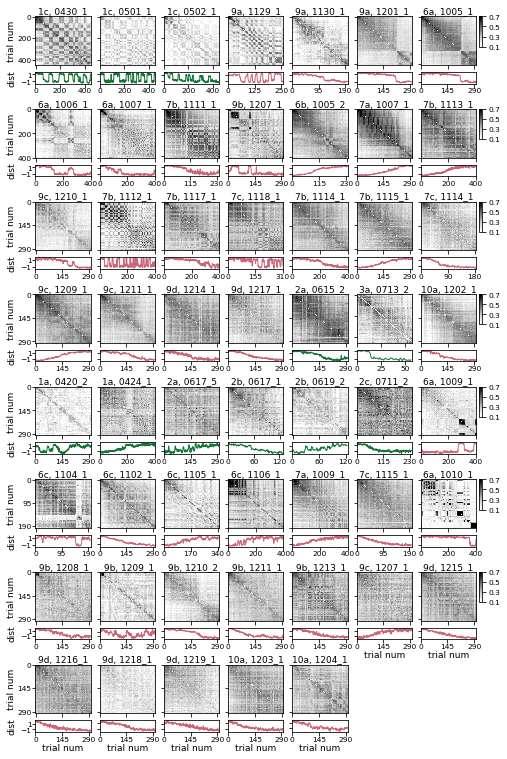

In [14]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(40, 77, hspace=0.6, wspace=1.2)
f = plt.figure(figsize=(8, 13.5))
i = -1
row = -5
for session in session_list_remaps:
#     print(row)
    # get mouse and session identity
    parts = session.split('_')
    m = parts[0]
    s = '{}_{}'.format(parts[1], parts[2])
    
    # get data
    i += 1
    d = data[m][s]
    A = d['A']  
    if m in ['Milan', 'Pisa', 'Hanover', 'Boston', 'Camden', 'Calais']:
        c1 = cp_color
    else:
        c1 = cr_color

    # get axes
    col = i%7
    col = col + col*10
    if col == 0:
#         if row < 24: 
#             row += 6
#         else:
        row += 5
    ax0 = plt.subplot(gs[row:row+3, col:col+10])# similarity
    ax1 = plt.subplot(gs[row+3, col:col+10])# distance to map

    # plot similarity
    sim = d['similarity']
    im = ax0.imshow(sim, clim=[0.1, 0.7], aspect='auto', cmap='Greys', interpolation='none')
    ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
              fontsize=9, pad=3)
        
    # plot distance to cluster (network)
    normalized_dd_all = d['dist']
    ax1.plot(normalized_dd_all, color=c1, lw=1, alpha=1)
    ax1.set_xlim([0, normalized_dd_all.shape[0]])
    ax1.set_yticks([-1, 1])
    
#     if session in two_maps:
#         # plot distance to cluster (cells)
#         ax2 = plt.subplot(gs[row+4, col])
#         dd_by_cell = d['cells_dist']
#         im = ax2.imshow(dd_by_cell, clim=[-1, 1], aspect='auto', cmap='binary')
#         ax2.set_ylim(ax2.get_ylim()[::-1])

    # axis labels
    if col == 0:
        ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
        ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
        ax1.set_ylabel('dist', fontsize=9, labelpad=4)
        ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
    else:
        ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    if col == 66:
        cbar = f.colorbar(im, cax=plt.subplot(gs[row:row+2, -1]), 
                          ticks=np.arange(0.1, 0.8, 0.2),
                          anchor=(0, 1))
        cbar.ax.tick_params(labelsize=7.5)
    if (col > 45) & (row > 25):
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    if row > 30:
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    
    # set axes
    if np.max(A[:, 2]) >= 399:
        ax1.set_xticks([0, 200, 400])
        ax0.set_yticks([0, 200, 400])
        ax0.set_xticks([0, 200, 400])
    else:
        ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax0.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
#     # 2-map session axes
#     if session in two_maps:
#         ax1.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
#         if col == 0:
#             ax2.set_ylabel('cells', fontsize=9, labelpad=1)
#             ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
#         else:
#             ax2.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
#         if np.max(A[:, 2]) >= 399:
#             ax2.set_xticks([0, 200, 400])
#         else:
#             ax2.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
# save data
f.savefig(save_folder + 'similarity_remaps_cells.png', dpi=400, bbox_inches='tight')
plt.show()

In [32]:
i

8

In [17]:
session_list_1 = ['Seattle_1010_1', 'Seattle_1009_1', 'Milan_0424_1', 
                  'Juneau_1102_1', 'Juneau_1106_1', 'Juneau_1105_1', 'Juneau_1104_1',
                  'Toronto_1114_1', 'Seattle_1007_1', 'Hanover_0617_5',
                  'Toronto_1112_1', 'Pisa_0502_1', 'Hanover_0615_2', 
                  'Toronto_1113_1', 'Milan_0420_2', 'Camden_0711_2', 
                  'Seattle_1006_1', 'Boston_0617_1', 'Quebec_1009_1', 
                  'Quebec_1007_1', 'Toronto_1111_1', 'Vancouver_1115_1', 
                  'Pisa_0430_1', 'Toronto_1115_1', 'Toronto_1117_1', 
                  'Vancouver_1114_1', 'Pisa_0501_1', 'Calais_0713_2',
                  'Vancouver_1118_1', 'Seattle_1005_1', 'Boston_0619_2', 
                  'Portland_1005_2']

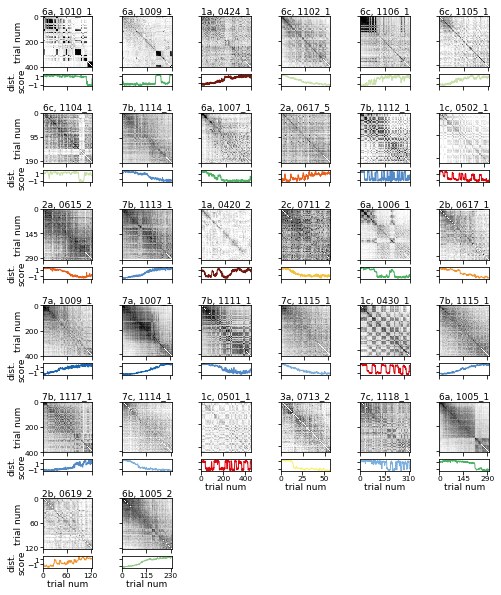

In [45]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(30, 6, hspace=0.6, wspace=0.6)
f = plt.figure(figsize=(8, 10.5))
i = -1
row = -5
for session in session_list_1:
    # get mouse and session identity
    parts = session.split('_')
    m = parts[0]
    s = '{}_{}'.format(parts[1], parts[2])
    
    # get data
    i += 1
    d = data[m][s]
    A = d['A']        
    c1 = colors[mice.index(m)]

    # get axes
    col = i%6
    if col == 0:
        row += 5 
    ax0 = plt.subplot(gs[row:row+3, col])# similarity
    ax1 = plt.subplot(gs[row+3, col])# distance to map

    # plot similarity
    sim = d['similarity']
    im = ax0.imshow(sim, clim=[0.1, 0.7], aspect='auto', cmap='Greys')
    ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
              fontsize=9, pad=3)
        
    # plot distance to cluster
    normalized_dd_all = d['dist']
    ax1.plot(normalized_dd_all, color=colors[mice.index(m)], lw=1, alpha=1)
    ax1.set_xlim([0, normalized_dd_all.shape[0]])
    ax1.set_yticks([-1, 1])

    # axis labels
    if col == 0:
        ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
        ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
        ax1.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)
        ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
    else:
        ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    if (col > 1) & (row == 20):
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    elif row == 25:
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    
    # set axes
    if np.max(A[:, 2]) >= 399:
        ax1.set_xticks([0, 200, 400])
        ax0.set_yticks([0, 200, 400])
        ax0.set_xticks([0, 200, 400])
    else:
        ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax0.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
# save data
f.savefig(save_folder + 'similarity_1.png', dpi=400, bbox_inches='tight')
plt.show()

In [39]:
session_list_2 = ['Camden_0711_2', 'Seattle_1010_1', 'Milan_0420_2', 
                  'Seattle_1009_1', 'Vancouver_1118_1', 'Juneau_1104_1',
                  'Seattle_1007_1', 'Toronto_1117_1', 'Juneau_1105_1', 
                  'Milan_0424_1', 'Toronto_1112_1', 'Seattle_1005_1', 
                  'Hanover_0617_5', 'Toronto_1111_1', 'Pisa_0502_1', 'Quebec_1007_1', 
                  'Portland_1005_2', 'Boston_0619_2', 'Juneau_1102_1', 
                  'Toronto_1114_1', 'Pisa_0430_1', 'Toronto_1113_1', 
                  'Vancouver_1115_1', 'Quebec_1009_1', 'Seattle_1006_1', 
                  'Boston_0617_1', 'Toronto_1115_1', 'Hanover_0615_2', 'Pisa_0501_1', 
                  'Juneau_1106_1', 'Vancouver_1114_1', 'Calais_0713_2']

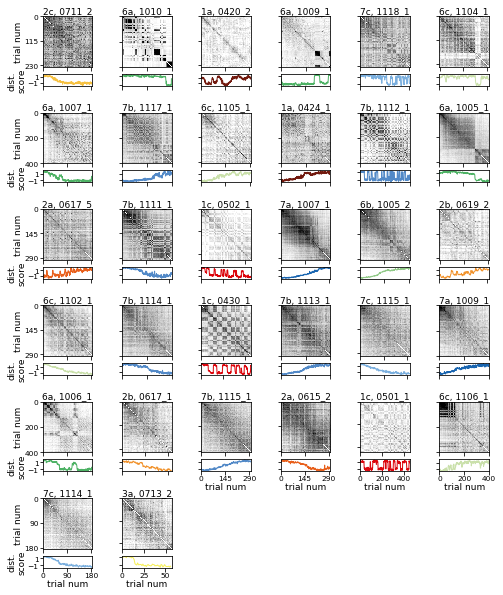

In [44]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(30, 6, hspace=0.6, wspace=0.6)
f = plt.figure(figsize=(8, 10.5))
i = -1
row = -5
for session in session_list_2:
    # get mouse and session identity
    parts = session.split('_')
    m = parts[0]
    s = '{}_{}'.format(parts[1], parts[2])
    
    # get data
    i += 1
    d = data[m][s]
    A = d['A']        
    c1 = colors[mice.index(m)]

    # get axes
    col = i%6
    if col == 0:
        row += 5 
    ax0 = plt.subplot(gs[row:row+3, col])# similarity
    ax1 = plt.subplot(gs[row+3, col])# distance to map

    # plot similarity
    sim = d['similarity']
    im = ax0.imshow(sim, clim=[0.1, 0.7], aspect='auto', cmap='Greys')
    ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
              fontsize=9, pad=3)
        
    # plot distance to cluster
    normalized_dd_all = d['dist']
    ax1.plot(normalized_dd_all, color=colors[mice.index(m)], lw=1, alpha=1)
    ax1.set_xlim([0, normalized_dd_all.shape[0]])
    ax1.set_yticks([-1, 1])

    # axis labels
    if col == 0:
        ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
        ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
        ax1.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)
        ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
    else:
        ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    if (col > 1) & (row == 20):
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    elif row == 25:
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    
    # set axes
    if np.max(A[:, 2]) >= 399:
        ax1.set_xticks([0, 200, 400])
        ax0.set_yticks([0, 200, 400])
        ax0.set_xticks([0, 200, 400])
    else:
        ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax0.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
# save data
f.savefig(save_folder + 'similarity_2.png', dpi=400, bbox_inches='tight')
plt.show()

In [41]:
session_list_3 = ['Seattle_1010_1', 'Seattle_1009_1', 'Milan_0424_1', 
                  'Juneau_1102_1', 'Juneau_1106_1', 'Juneau_1105_1', 'Juneau_1104_1', 
                  'Toronto_1114_1', 'Seattle_1007_1', 'Hanover_0617_5',
                  'Toronto_1112_1', 'Pisa_0502_1', 'Hanover_0615_2', 
                  'Toronto_1113_1', 'Milan_0420_2', 'Camden_0711_2', 
                  'Seattle_1006_1', 'Boston_0617_1', 'Quebec_1009_1', 
                  'Quebec_1007_1', 'Toronto_1111_1', 'Vancouver_1115_1', 
                  'Pisa_0430_1', 'Toronto_1115_1', 'Toronto_1117_1', 
                  'Vancouver_1114_1', 'Pisa_0501_1', 'Calais_0713_2',
                  'Vancouver_1118_1', 'Seattle_1005_1', 'Boston_0619_2', 
                  'Portland_1005_2']

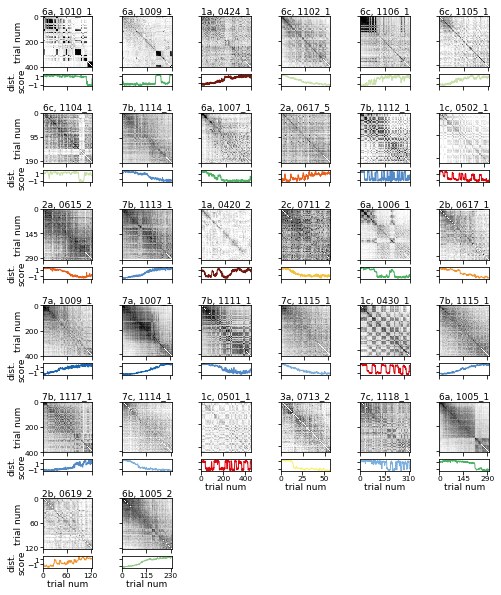

In [43]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(30, 6, hspace=0.6, wspace=0.6)
f = plt.figure(figsize=(8, 10.5))
i = -1
row = -5
for session in session_list_3:
    # get mouse and session identity
    parts = session.split('_')
    m = parts[0]
    s = '{}_{}'.format(parts[1], parts[2])
    
    # get data
    i += 1
    d = data[m][s]
    A = d['A']        
    c1 = colors[mice.index(m)]

    # get axes
    col = i%6
    if col == 0:
        row += 5 
    ax0 = plt.subplot(gs[row:row+3, col])# similarity
    ax1 = plt.subplot(gs[row+3, col])# distance to map

    # plot similarity
    sim = d['similarity']
    im = ax0.imshow(sim, clim=[0.1, 0.7], aspect='auto', cmap='Greys')
    ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
              fontsize=9, pad=3)
        
    # plot distance to cluster
    normalized_dd_all = d['dist']
    ax1.plot(normalized_dd_all, color=colors[mice.index(m)], lw=1, alpha=1)
    ax1.set_xlim([0, normalized_dd_all.shape[0]])
    ax1.set_yticks([-1, 1])

    # axis labels
    if col == 0:
        ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
        ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
        ax1.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)
        ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
    else:
        ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    if (col > 1) & (row == 20):
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    elif row == 25:
        ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
    
    # set axes
    if np.max(A[:, 2]) >= 399:
        ax1.set_xticks([0, 200, 400])
        ax0.set_yticks([0, 200, 400])
        ax0.set_xticks([0, 200, 400])
    else:
        ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax0.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
        ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
# save data
f.savefig(save_folder + 'similarity_3.png', dpi=400, bbox_inches='tight')
plt.show()

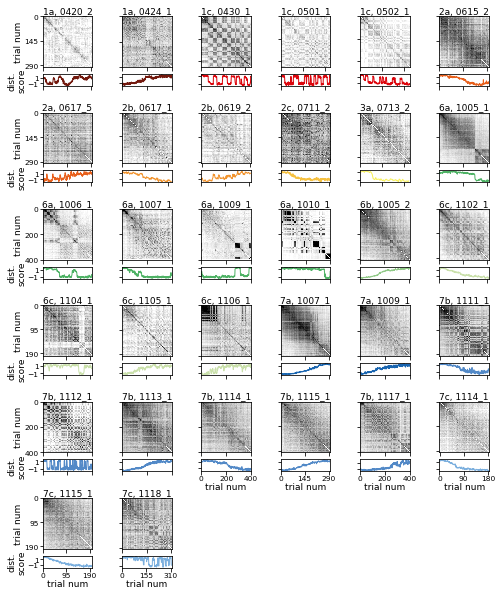

In [46]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(30, 6, hspace=0.6, wspace=0.6)
f = plt.figure(figsize=(8, 10.5))
i = -1
row = -5
for m, session in zip(mice, sessions):
    for s in session:
        # get data
        i += 1
        d = data[m][s]
        A = d['A']        
        c1 = colors[mice.index(m)]

        # get axes
        col = i%6
        if col == 0:
            row += 5 
        ax0 = plt.subplot(gs[row:row+3, col])# similarity
        ax1 = plt.subplot(gs[row+3, col])# distance to map

        # plot similarity
        sim = d['similarity']
        im = ax0.imshow(sim, clim=[0.1, 0.7], aspect='auto', cmap='Greys')
        ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
                  fontsize=9, pad=3)

        # plot distance to cluster
        normalized_dd_all = d['dist']
        ax1.plot(normalized_dd_all, color=colors[mice.index(m)], lw=1, alpha=1)
        ax1.set_xlim([0, normalized_dd_all.shape[0]])
        ax1.set_yticks([-1, 1])

        # axis labels
        if col == 0:
            ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
            ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
            ax1.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)
            ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
        else:
            ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
            ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
        if (col > 1) & (row == 20):
            ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
        elif row == 25:
            ax1.set_xlabel('trial num', fontsize=9, labelpad=1)

        # set axes
        if np.max(A[:, 2]) >= 399:
            ax1.set_xticks([0, 200, 400])
            ax0.set_yticks([0, 200, 400])
            ax0.set_xticks([0, 200, 400])
        else:
            ax0.set_yticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
            ax0.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
            ax1.set_xticks([0, np.round(np.max(A[:, 2]-5), -1)//2, np.round(np.max(A[:, 2]-5), -1)])
    
# save data
f.savefig(save_folder + 'similarity_ordered.png', dpi=400, bbox_inches='tight')
plt.show()

In [4]:
''' run analysis on double-track sessions with >10 MEC neurons '''
mice = ['Seoul', 'Degu', 'Busan', 'Inchon', 'Ulsan']

mouse_IDs = ['4a', '4b', '4c', '5a', '5b']

sessions = [['0720cr', '0720cp', '0721cr', '0721cp'], # Seoul
            ['0720cr', '0720cp', '0721cr', '0721cp', '0722cr', '0722cp'], # Degu
            ['0730cr', '0730cp', '0801cr', '0801cp', '0802cr', '0802cp', '0803cr', '0803cp'], # Busan 
            ['0810cr', '0810cp', '0812cr', '0812cp', '0814cr', '0814cp'], # Inchon
            ['0802cr', '0802cp']] # Ulsan

In [5]:
print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions (split): ' + str(N_sessions))

# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

N mice: 5
N sessions (split): 26


In [6]:
''' Assign color to each mouse - colorblind friendly: '''
colors = np.asarray([[136, 46, 114, 255], [153, 79, 136, 255], [170, 111, 158, 255], # dark purples
          [186, 141, 180, 255], [209, 187, 215, 255]]) # light purples
colors = colors/255
colors = list(colors)
for i, c in enumerate(colors):
    colors[i] = tuple(c)

In [7]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        
        # load the data
        d['Y'] = np.load(data_folder + 'gap_corrected/{}_{}_MEC_FRtensor.npy'.format(m, s))
        d['A'] = np.load(data_folder + 'gap_corrected/{}_{}_behavior.npy'.format(m, s))  

In [8]:
# calculate similarity score across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [9]:
''' fit kmeans to get remaps '''
N = 2
model_kmeans = lvl_kmeans(n_components=N, n_restarts=30)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat 

In [10]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        H = d['kmeans']['H']
        
        # get map indices
        map_idx = W[:, 0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1
        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)

        # get running speed in each map and assign map 0 to slower map
        speed = A[:, 1]
        speed_0 = np.nanmean(speed[map0_idx])
        speed_1 = np.nanmean(speed[map1_idx])

        if speed_1 < speed_0: # swap labels
            d['map0_idx'] = 1
        else:
            d['map0_idx'] = 0

In [11]:
''' get distance to cluster on each trial '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        n_trials, n_cells, n_pos = Y.shape

        # get kmeans fit
        H = d['kmeans']['H']
        N = H.shape[0]
        map0_idx = d['map0_idx']

        # get centroids
        c1 = H[map0_idx]
        c2 = H[map0_idx-1]
        
        # project down to connecting line
        proj = (c1 - c2) / np.linalg.norm(c1 - c2)
        projc1 = c1 @ proj
        projc2 = c2 @ proj
        projY = Y_unwrapped @ proj
        
        # get distance
        dd = (projY - projc2) / (projc1 - projc2)
        d['dist'] = 2 * (dd - .5) # classify -1 or 1

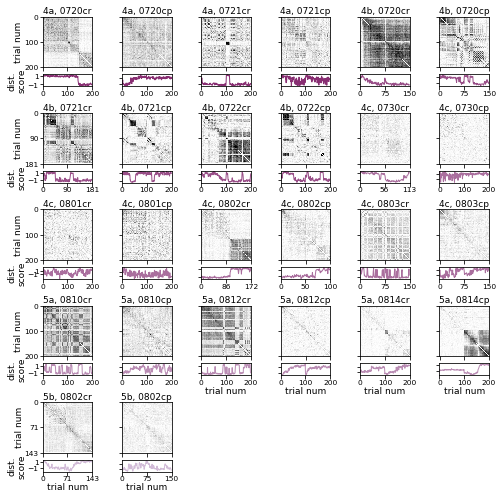

In [13]:
''' plot similarity and distance to cluster in one big figure '''
gs = gridspec.GridSpec(30, 6, hspace=0.6, wspace=0.6)
f = plt.figure(figsize=(8, 10.5))
i = -1
row = -5
for m, session in zip(mice, sessions):
    for s in session:
        # get data
        i += 1
        d = data[m][s]
        A = d['A']        
        c1 = colors[mice.index(m)]

        # get axes
        col = i%6
        if col == 0:
            row += 5 
        ax0 = plt.subplot(gs[row:row+3, col])# similarity
        ax1 = plt.subplot(gs[row+3, col])# distance to map

        # plot similarity
        sim = d['similarity']
        im = ax0.imshow(sim, clim=[0, 0.7], aspect='auto', cmap='Greys')
        ax0.set_title('{}, {}'.format(mouse_IDs[mice.index(m)], s), 
                  fontsize=9, pad=3)

        # plot distance to cluster
        normalized_dd_all = d['dist']
        ax1.plot(normalized_dd_all, color=colors[mice.index(m)], lw=1, alpha=1)
        ax1.set_xlim([0, normalized_dd_all.shape[0]])
        ax1.set_yticks([-1, 1])

        # axis labels
        if col == 0:
            ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
            ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
            ax1.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)
            ax1.tick_params(which='major', labelsize=7.5, pad=0.5)
        else:
            ax0.tick_params(labelbottom=False, labelleft=False, which='major', labelsize=7.5, pad=0.5)
            ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
        if (col > 1) & (row == 15):
            ax1.set_xlabel('trial num', fontsize=9, labelpad=1)
        elif row == 20:
            ax1.set_xlabel('trial num', fontsize=9, labelpad=1)

        # set axes
        trial_num = sim.shape[0]
        if trial_num >= 200:
            ax1.set_xticks([0, 100, 200])
            ax0.set_yticks([0, 100, 200])
            ax0.set_xticks([0, 100, 200])
        else:
            ax0.set_yticks([0, trial_num//2, trial_num])
            ax0.set_xticks([0, trial_num//2, trial_num])
            ax1.set_xticks([0, trial_num//2, trial_num])
    
# save data
f.savefig(save_folder + 'similarity_ordered_2track.png', dpi=400, bbox_inches='tight')
plt.show()